## SKIN LESION SEGMENTATION WITH DEEP LEARNING (U-Net)
MAIA 2021 -2023


*   BORRAS LLUIS
*   CISNEROS JUAN
*   LEON SOFIA


# In  Brief

The goal of this analysis is to train and test a deep learning U-Net algorithm to accurately segment skin lesions from ISIC-2017 challenge Datasets.


In [ ]:
# remove these lines if not running on notebooks
#%matplotlib notebook
run_from_notebook = False


## Import the required packages
Import requeried packages

In [ ]:

import os
import pandas as pd
from torchvision.io import read_image
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict


## Hyperparameters and options
Hyperparameters setting to compare between experiments. Switch between pretrained true or false and options to work with and without GPU together with colab_failsafe to reload experiment if Google Colab fails.


In [ ]:

# Hyperparameters
batch_size = 16
batch_size_val = 10
learning_rate = 0.0001
epochs = 100
flag_scheduler = 0 # 0: for StepLR, 1: for CosineAnnealingLR
# Scheduler StepLR
lr_step_size = 120  # if < than epochs no scheduer performed
lr_gamma = 0.1
# Scheduler CosineAnnealingLR
eta_min=0.00001
t_max = 5
# Data augmentation
data_augmentation = True
probability_DA = 0.4
# Dropout 
dropout = 0.1
# Resize image paramenter
resize_param = [256, 320]
# Activation function
activation = nn.ReLU()

# Options
# Make visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# how many workers for fetching data
num_workers = os.cpu_count()
monitor_display = True     # whether to display monitored performance plots
# Check number of workers and device
print(num_workers)
print(device)

# To traine model or test a pretrained model
pretrained = True 
# Google Colab failsafe
colab_failsafe = False


4
cuda:0


## Define the model architecture
Modified U-Net.
Definition of the class UNet with the __init__ function that defines the complete architecture of the symetrical U-NET with its 3 different parts, encoder-bottleneck-decoder followed by the forward function defining the path that will follow the data from input to output and the block function with the two 3x3 convolutions. Also is define the class DiceLoss that will be use by the citerion as loss function.

In [ ]:

class UNet(nn.Module):

  def __init__(self, in_channels=3, out_channels=1, init_features=32):
    super(UNet, self).__init__()
    
    features = init_features
    self.encoder1 = UNet._block(in_channels, features, name="enc1")
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.encoder2 = UNet._block(features, features * 2, name="enc2")
    self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
    self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
    self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
    self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.bottleneck = UNet._block(features * 16, features * 32, name="bottleneck")

    self.upconv5 = nn.ConvTranspose2d(features * 32, features * 16, kernel_size=2, stride=2)
    self.decoder5 = UNet._block((features * 16) * 2, features * 16, name="dec5")
    self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
    self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
    self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
    self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
    self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
    self.decoder1 = UNet._block(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1, bias=True)

  def forward(self, x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(self.pool1(enc1))
    enc3 = self.encoder3(self.pool2(enc2))
    enc4 = self.encoder4(self.pool3(enc3))
    enc5 = self.encoder5(self.pool4(enc4))

    bottleneck = self.bottleneck(self.pool5(enc5))


    dec5 = self.upconv5(bottleneck)
    dec5 = torch.cat((dec5, enc5), dim=1)
    dec5 = self.decoder5(dec5)
    dec4 = self.upconv4(dec5)
    dec4 = torch.cat((dec4, enc4), dim=1)
    dec4 = self.decoder4(dec4)
    dec3 = self.upconv3(dec4)
    dec3 = torch.cat((dec3, enc3), dim=1)
    dec3 = self.decoder3(dec3)
    dec2 = self.upconv2(dec3)
    dec2 = torch.cat((dec2, enc2,), dim=1)
    dec2 = self.decoder2(dec2)
    dec1 = self.upconv1(dec2)
    dec1 = torch.cat((dec1, enc1,), dim=1)
    dec1 = self.decoder1(dec1)

    return torch.sigmoid(self.conv(dec1))


  def _block(in_channels, features, name):
    return nn.Sequential(
      OrderedDict(
        [
          (
            name + "conv1",
            nn.Conv2d(
              in_channels=in_channels,
              out_channels=features,
              kernel_size=3,
              padding=1,
              bias=True,
            ),
          ),
          (name + "norm1", nn.BatchNorm2d(num_features=features)),
          (name + "relu1", activation),
          (name + "drop1", nn.Dropout(dropout)),
          (
            name + "conv2",
            nn.Conv2d(
              in_channels=features,
              out_channels=features,
              kernel_size=3,
              padding=1,
              bias=True,
            ),
          ),
          (name + "norm2", nn.BatchNorm2d(num_features=features)),
          (name + "relu2", activation),
          (name + "drop2", nn.Dropout(dropout)),
        ]
      )
    )


class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-05

    def forward(self, y_pred, y_true):
        dscs = torch.zeros(len(y_pred))
        
        for i in range(len(y_pred)):
          y_pred_ch = (y_pred[i].contiguous().view(-1)).cpu()
          y_true_ch = y_true[i].contiguous().view(-1)
          intersection = (y_pred_ch * y_true_ch).sum()
          dscs[i] = (2. * intersection + self.smooth) / (
              y_pred_ch.sum() + y_true_ch.sum() + self.smooth
          )
        return 1. - torch.mean(dscs)    

JACCARD AND DICE SCORE FUNCTIONS

In [ ]:

def dice_coeff_v2(y_true, y_pred):
    """
            DSC = (2 * |X & Y|)/ (|X|+ |Y|)
                = 2 * sum(|A*B|)/(sum(|A|)+sum(|B|))
    :param y_true: ground truth
    :param y_pred: prediction
    :return:
    """
    dice_batch = 0.0
    for i in range(len(y_true)):
      true_mask = torch.squeeze(y_true[i]).cpu().detach().numpy()
      pred_mask = torch.squeeze(y_pred[i]).cpu().detach().numpy()
      dice = 2 * np.sum(true_mask * pred_mask) / (np.sum(np.abs(true_mask)) + np.sum(np.abs(pred_mask)))
      dice_batch += dice
    return dice_batch


def jaccard_index(y_true, y_pred):
    """
        Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
                = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
        """
    jacc_batch = 0.0
    for i in range(len(y_true)):
      true_mask = torch.squeeze(y_true[i]).cpu().detach().numpy()
      pred_mask = torch.squeeze(y_pred[i]).cpu().detach().numpy()
      jacc = np.sum(np.abs(true_mask * pred_mask)) / (np.sum(np.abs(true_mask)) + np.sum(np.abs(pred_mask)) - np.sum(true_mask * pred_mask))
      jacc_batch += jacc
    return jacc_batch


## Create the building blocks for training
Create an instance of the network and the associate name experiment_ID, the loss function, the optimizer, and learning rate scheduler.

In [ ]:
# Network
net = UNet()

# Create loss function
criterion = DiceLoss()

# Create ADAM optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Create different learning rate schedulers
if flag_scheduler == 0:
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
elif flag_scheduler == 1:
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
print(scheduler)

# experiment_ID
experiment_ID = "%s_%s_%s_bs(%d)lr(%.4f_%d_%.1f)e(%d)act(%s)da(%s)do(%.1f)BN_Normalize_probDa(%.1f)_avgPool32_biasTrue_biigerimage_enc5_cosine" % (type(net).__name__, type(criterion).__name__, type(optimizer).__name__,
                batch_size, learning_rate, lr_step_size, lr_gamma, epochs, type(activation).__name__, data_augmentation, dropout, probability_DA)
print(experiment_ID)


UNet_DiceLoss_Adam_bs(16)lr(0.0001_120_0.1)e(100)act(ReLU)da(True)do(0.1)BN_Normalize_probDa(0.4)_avgPool32_biasTrue_biigerimage_enc5_cosine


## Create datasets
A custom image dataset class was created following Pytorch guidelines to load and process/augment our image Dataset, definintion of _init_, _len_, and _getitem_ functions of the class. Definiton of my_collate that will be used the dataloader and show_image_batch to show n batches after transformations.

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, mask_dir, image_dir, transform=None, target_ori_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.mask_dir = mask_dir
        self.img_dir = image_dir
        self.transform = transform
        self.target_ori_transform = target_ori_transform

    def __len__(self): #check the size of the dataset
        return len(self.img_labels)

    def __getitem__(self, idx): # read one image
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0] + '_segmentation.png')
        image = read_image(img_path)
        mask_ori = read_image(mask_path)
        mask_ori[mask_ori == 255] = 1
        name = self.img_labels.iloc[idx, 0];

        seed = np.random.randint(651998) # make a seed with numpy generator 
        if self.transform:
            torch.manual_seed(seed)
            image = self.transform(image)
        if self.target_ori_transform:
            torch.manual_seed(seed)
            mask_ori = self.target_ori_transform(mask_ori)
        return image, mask_ori, name


def my_collate(batch):
    data = [item[0] for item in batch]
    target_ori =[item[1] for item in batch]
    data = torch.stack(data, dim=0)
    name = [item[2] for item in batch]
    return [data, target_ori, name] 


def show_image_batch(img_list):
    num = len(img_list)
    fig = plt.figure(figsize=(64,64))
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        img=img_list[i].numpy().transpose([1,2,0])
        ax.imshow(img.astype(int))
        # ax.set_title(title[i])
    plt.show()


Loading the ISIC Dataset as custom Dataset to be ready for the Dataloader with the split training/validation/test, following ISIC 2017 dataset recomendation 2000/150/600.

Mounted at /content/drive
torch.Size([3, 767, 1022])
<class 'torch.Tensor'>


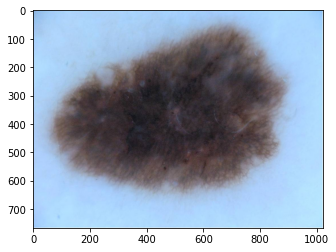

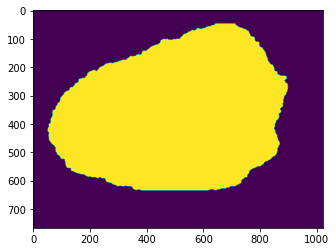

In [ ]:

# Load our google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Dataset train
dir_train_images = '/content/drive/MyDrive/ISIC-2017_Training_Data/'
dir_train_masks = '/content/drive/MyDrive/ISIC-2017_Training_Mask/'
annotations_file_train = '/content/drive/MyDrive/ISIC-2017_Training_Mask/ISIC-2017_Training_Part3_GroundTruth.csv'
dataset_train = CustomImageDataset(image_dir=dir_train_images, mask_dir = dir_train_masks ,annotations_file=annotations_file_train)

# Plotting 1 image and mask to check
image, mask_ori, name =dataset_train[0]
print(image.shape)
print(type(image))
plt.figure(0)
plt.imshow(image.numpy().transpose([1,2,0]))
plt.figure(1)
plt.imshow(torch.squeeze(mask_ori))

if not pretrained:
  # Dataset validation
  dir_valid_images = '/content/drive/MyDrive/ISIC-2017_Validation_Data/'
  dir_valid_masks = '/content/drive/MyDrive/ISIC-2017_Validation_Part1_GroundTruth/'
  annotations_file_valid = '/content/drive/MyDrive/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part3_GroundTruth.csv'
  dataset_valid = CustomImageDataset(image_dir=dir_valid_images, mask_dir = dir_valid_masks ,annotations_file=annotations_file_valid)
else:
  # Dataset test
  dir_test_images = '/content/drive/MyDrive/ISIC-2017_Test_v2_Data/'
  dir_test_masks = '/content/drive/MyDrive/ISIC-2017_Test_v2_Part1_GroundTruth/'
  annotations_file_test = '/content/drive/MyDrive/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
  dataset_test = CustomImageDataset(image_dir=dir_test_images, mask_dir = dir_test_masks, annotations_file=annotations_file_test)


Mean and Standard deviation were calculated outside of collab per channel


In [ ]:

# Train set statistics
mu_train_r=180.514
mu_train_b=139.454
mu_train_g=150.850
std_train_r=35.242
std_train_b=35.249
std_train_g=35.250

# Validation Set statistics
mu_val_r=176.615
mu_val_b=130.143
mu_val_g=142.922
std_val_r=34.276
std_val_b=34.287
std_val_g=34.319

# Test Set statistics
mu_test_r=181.740
mu_test_b=129.762
mu_test_g=140.271
std_test_r=38.435
std_test_b=38.439
std_test_g=38.438


## Define data transforms
Data transforms are applied when the custom Dataset is called through the Dataloader.

A serie of transformations are defined. First Convert Class will convert the data to a tensor once called. Two possible transformations are defined for the data. Without and with Data Augmentation just applied in the training set. In both cases the class Convert is called together with the resizing of the images to a resize_param defined in the hyperparameters area, and the standarization of the data with the means (mu) and standard deviation (std) calculated averaging the whole training, validation and test set separately. 
If choose the Data augmentation will perform a random rotation, vertical and horizontal flip, affine transformation compose by scaling, transposing and shearing and a perspective rotation with a probability occurance define in the parameter probability_DA.

In [ ]:

# define Convert transform to convert custom Dataset images to torch float tensors
# the operations are (in sequence):
# - 'np.array' to convert the image to a numpy array
# - 'torch.from_numpy' to convert the numpy array to torch tensor
# - '.float()' to convert to float tensors, since deep learning builds on float numbers
class Convert(object):
  def __call__(self, img):
       return torch.from_numpy(np.array(img)).float()

# Definition of data transformations as a composition of Data Augmentation (training only), Convert, Normalize, and Resize
# here, Normalize implements standardization using the previously computed mu and std by channel

DataAugmentation = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(50), transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(), 
                                                               transforms.RandomAffine(degrees=0, scale=(.9, 1.1), translate=(0.3, 0.3), shear=20), transforms.RandomPerspective(distortion_scale=0.3)]), p=probability_DA)


transform_train_augmentation = transforms.Compose([Convert(), DataAugmentation, transforms.Resize(size = resize_param),
                                                  transforms.Normalize(mean=[mu_train_r, mu_train_g, mu_train_b], std=[std_train_r, std_train_g, std_train_b])])

transform_train = transforms.Compose([Convert(), transforms.Resize(size = resize_param),
                                      transforms.Normalize(mean=[mu_train_r, mu_train_g, mu_train_b], std=[std_train_r, std_train_g, std_train_b])])

transform_valid = transforms.Compose([Convert(), transforms.Resize(size = resize_param), 
                                      transforms.Normalize(mean=[mu_val_r, mu_val_g, mu_val_b], std=[std_val_r, std_val_g, std_val_b])])

transform_test = transforms.Compose([Convert(), transforms.Resize(size = resize_param),
                                     transforms.Normalize(mean=[mu_test_r, mu_test_g, mu_test_b], std=[std_test_r, std_test_g, std_test_b])])

transform_orilabels = Convert()

transform_orilabels_augmentation = transforms.Compose([Convert(), DataAugmentation])

# Set data and target transforms on both datasets
# Same transforms (except for data augmentation) on both training and validation/test sets to avoid introducing biases
if data_augmentation:
  dataset_train.transform = transform_train_augmentation
  dataset_train.target_ori_transform = transform_orilabels_augmentation
else:
  dataset_train.transform = transform_train
  dataset_train.target_ori_transform = transform_orilabels
if not pretrained:
  dataset_valid.transform = transform_valid
  dataset_valid.target_ori_transform = transform_orilabels
else:
  dataset_test.transform = transform_test
  dataset_test.target_ori_transform = transform_orilabels

## Create data loaders
Dataloaders to sample batches from custom Datasets. 3 dataloaders are defined. The train dataloader fetches the images for the batches randomly with a specific batch size and with the help of my_collate function. Instead the dataloaders for validation and test fetches the images for the batches without shuffling.

In [ ]:
# create data loaders
# NOTE 1: shuffle helps training
# NOTE 2: in test mode, batch size can be as high as the GPU can handle (faster, but requires more GPU RAM)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
if not pretrained:
  dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_val, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
else:
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_val, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)

## Check your data after transformations are applied in one batch
To check what the network will see at train/test time after transformations are appplied.

125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

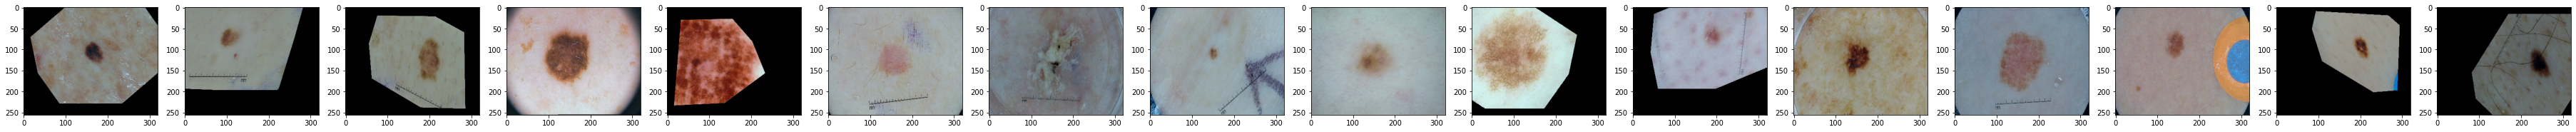

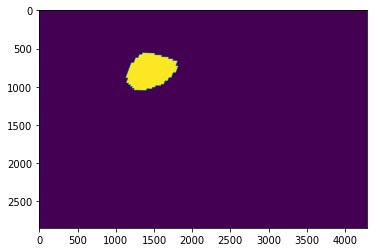

In [ ]:
print(len(dataloader_train))
# # # visual check
for i, minibatch in enumerate(dataloader_train):
  if i >= 1:
    break
  data, masks_ori, names = minibatch
  data=data*std_train_b+mu_train_b
  show_image_batch(data)
  plt.figure(2)
  plt.imshow(torch.squeeze(masks_ori[1]))

## Define train function
Definition of the train function that will be call at each epoch during training the U-Net. Returns the Jaccard and Dice coefficient scores together with the average loss.

In [ ]:

def train(dataset, dataloader):

    # Switch to train mode
    net.train()

    # reset performance measures
    loss_sum = 0.0
    dice_sum = 0.0
    jacc_sum = 0.0

    # 1 epoch = 1 complete loop over the dataset
    for batch in dataloader:

        # Get data from dataloader
        inputs, targets_original_size, name = batch
        # targets = torch.squeeze(targets, dim=0)

        # Move data to device
        inputs = inputs.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Resizing outputs to the original size
        output_original_size=[]
        for i in range(len(targets_original_size)):
          height = targets_original_size[i].shape[1]
          width = targets_original_size[i].shape[2]
          output_original_size.append(transforms.functional.resize(outputs[i], (height, width)))

        # Calculate loss
        loss = criterion(output_original_size, targets_original_size)

        # Loss gradient backpropagation
        loss.backward()

        # Net parameters update
        optimizer.step()

        # Accumulate loss
        loss_sum += loss.item()

        # Acumulate scores
        dice= dice_coeff_v2(targets_original_size, output_original_size)
        jacc = jaccard_index(targets_original_size, output_original_size)
        dice_sum += dice
        jacc_sum += jacc

    # Step learning rate scheduler
    scheduler.step()

    # return average loss, jaccard and dice
    return loss_sum / len(dataloader), (100. * jacc_sum / len(dataset)), (100. * dice_sum / len(dataset))

## Define test function
For instance, during training for validation at each epoch, or after training for testing the model. Returns the jaccard and dice metrix togheter with the segmentation maps obtained.

In [ ]:
# define test function
def test(dataset, dataloader):

    # Switch to test mode
    net.eval()  

    # Initialize predictions
    predictions = torch.zeros((len(dataset), 1, resize_param[0], resize_param[1]), dtype=torch.int64)
    dice_sum = 0.0
    jacc_sum = 0.0
    sample_counter = 0

    # Do not accumulate gradients
    with torch.no_grad():

        # test all batches
        for batch in dataloader:
            
            # Get data from dataloader the rest is not used in test mode
            inputs, targets_original_size, names = batch

            # Move data to device
            inputs = inputs.to(device, non_blocking=True)

            # Forward pass
            outputs = net(inputs)
            outputs_binary = torch.round(outputs)
            
            # Resize outputs to original size to compute scores
            output_binary_original_size=[]
            for i in range(len(targets_original_size)):
              height = targets_original_size[i].shape[1]
              width = targets_original_size[i].shape[2]
              output_binary_original_size.append(transforms.functional.resize(outputs_binary[i], (height, width)))

            # Acumulate scores
            dice= dice_coeff_v2(targets_original_size, output_binary_original_size)
            jacc = jaccard_index(targets_original_size, output_binary_original_size)
            dice_sum += dice
            jacc_sum += jacc

            # Store predictions
            for output in outputs_binary:
                predictions[sample_counter] = output
                sample_counter += 1

            # Store predictions for machine learning
            # for i in range(len(predictions)):
            #   name = names[i]
            #   store(predictions[i], name, '/content/drive/MyDrive/Skin_Lesion/predictions_train/', '_prediction.png')

    return (100. * jacc_sum / len(dataset)), (100. * dice_sum / len(dataset)), predictions

If Google Colab fails reload experiment to continue running

In [ ]:
if colab_failsafe:
  path = "/content/drive/MyDrive/train_networks/" 

  experiment_ID_load = "UNet_DiceLoss_Adam_bs(16)lr(0.0002_60_0.1)e(100)act(ReLU)da(True)do(0.1)BN_Normalize_probDa(0.3)_avgPool32_biasTrue_biigerimage_enc5_cosine"

  checkpoint = torch.load(path + experiment_ID_load + ".tar", map_location=lambda storage, loc: storage)
  epochs_net = checkpoint['epoch']
  valid_jacc_net = checkpoint['accuracy']
  train_jacc_net = checkpoint['accuracy_train']
  net.load_state_dict(checkpoint['net_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  loss_net = checkpoint['loss']
  epoch_time_net = checkpoint['epoch_time_net'] 
  print("network loaded succesfully")


## Train a new model or test a pretrained one
The code below also includes visual loss/jaccard index monitoring during training, both on training and validation sets. 

In [ ]:
# to save and load model
path = "/content/drive/MyDrive/SkinLesionsSegmentationClassificationMaterial/UNet/" 
graph_path = "/content/drive/MyDrive/Graphs_train_networks/"

# pretrained = False, train the model and test with validations
if not pretrained:

    if not colab_failsafe:
        # Reset performance monitors
        epoch_time = []
        losses = []
        train_jaccs = []
        train_dices = []
        valid_jaccs = []
        valid_dices = []
        ticks = []
        start = 1

    else:
      # Continious from previous performances
      epoch_time = epoch_time_net
      losses = loss_net
      train_jaccs = train_jacc_net
      valid_jaccs = valid_jacc_net
      ticks = epochs_net
      train_dices = []
      valid_dices = []
      start = max(ticks)+1
    
    # Move net to device
    net.to(device)

    # Start training
    for epoch in range(start, epochs+1):
        for param_group in optimizer.param_groups:
          print(param_group['lr'])
        
        # Measure time elapsed
        t0 = time.time()
        
        # Train
        avg_loss, jacc_train, dice_train = train(dataset_train, dataloader_train)

        # Test on validation
        jacc_val, dice_val, predictions = test(dataset_valid, dataloader_valid)
                    
        # Update performance history
        epoch_time.append(time.time()-t0)
        losses.append(avg_loss)
        train_jaccs.append(jacc_train)
        train_dices.append(dice_train)
        valid_jaccs.append(jacc_val)
        valid_dices.append(dice_val)
        ticks.append(epoch)

        # Print or display performance
        if not monitor_display:
            print ("\nEpoch %d\n"
                "...TIME: %.1f seconds\n"
                "...loss: %g (best %g at epoch %d)\n"
                "...training accuracy: %.2f%% (best %.2f%% at epoch %d)\n"
                "...validation accuracy: %.2f%% (best %.2f%% at epoch %d)" % (
                epoch,
                time.time()-t0,
                avg_loss, min(losses), ticks[np.argmin(losses)],
                jacc_train,
                max(train_jaccs),
                ticks[np.argmax(train_jaccs)],
                jacc_val, max(valid_jaccs), ticks[np.argmax(valid_jaccs)]))
        else:
            # Time per epoch
            print ("TIME: %.1f seconds\n" % (time.time()-t0))
            # Plot
            fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
            ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel(type(criterion).__name__, color='blue')
            ax1.set_ylim(0.01, 1)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_yscale('log')
            ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True, 
                label = 'Training loss: %.2f (best at ep. %d)' % (avg_loss, ticks[np.argmin(losses)]))
            ax1.legend(loc="lower left")
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.set_ylabel('JaccardIndex %', color='red')
            ax2.set_ylim(64, 86)
            ax2.set_yticks(np.arange(56, 86, step=2))
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.plot(ticks, train_jaccs, 'r-', linewidth=1.0, aa=True, 
                label='Training (Jacc: %.2f%% Dice: %.2f%%, best %.2f%% at ep. %d)' % (jacc_train, dice_train, max(train_jaccs), ticks[np.argmax(train_jaccs)]))
            ax2.plot(ticks, valid_jaccs, 'r--', linewidth=1.0, aa=True, 
                label='Validation (Jacc: %.2f%% Dice: %.2f%%, best %.2f%% at ep. %d)' % (jacc_val, dice_val, max(valid_jaccs), ticks[np.argmax(valid_jaccs)]))
            ax2.legend(loc="lower right")
            plt.xlim(0, epochs+1)
            # Saving the plot
            plt.savefig(graph_path+experiment_ID + ".png", dpi=300)
            # this works if running from notebooks
            if run_from_notebook:
                fig.show()
                fig.canvas.draw()
            # this works if running from console
            else:
                plt.draw()
                plt.show()
            fig.clear()

        # Save model if validation performance has improved
        if (epoch-1) == np.argmax(valid_jaccs):
            torch.save({
            'net_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':  scheduler.state_dict(),
            'loss': losses,
            'accuracy': valid_jaccs,
            'accuracy_train':train_jaccs,
            'epoch': ticks,
            'epoch_time_net': epoch_time
            }, path + experiment_ID + ".tar")
            print('Model saved!')

# pretrained = True, test the model on the test set
else:
    experiment_ID_load = "Unet_Experiment_7"

    # load pretrained model
    checkpoint = torch.load(path + experiment_ID_load + ".tar", map_location=lambda storage, loc: storage)

    net.load_state_dict(checkpoint['net_state_dict'])
    loss_net = checkpoint['loss']
    epochs_net = checkpoint['epoch']
    valid_jacc_net = checkpoint['accuracy']
    train_jacc_net = checkpoint['accuracy_train']
    epoch_time_net = checkpoint['epoch_time_net'] 

    print ("Loaded pretrained model\n...reached jaccard of %.2f%% in validation and %.2f%% in training, best epoch %d in a total time of %.2f%%" 
           % (max(valid_jacc_net), max(train_jacc_net), max(epochs_net), sum(epoch_time_net)/3600))

    # move net to device
    net.to(device)

    # test
    jacc_test, dice_test, predictions = test(dataset_test, dataloader_test)

    print ("Jacc on test set is %.2f%%" % jacc_test)
    print ("Dice on test set is %.2f%%" % dice_test)
    


Loaded pretrained model
...reached jaccard of 76.41% in validation and 83.18% in training, best epoch 55 in a total time of 16.03%
Jacc on test set is 74.91%
Dice on test set is 83.70%


In [ ]:
# Google colab hack
while True:pass

Function to store the predictions for Machine learning

In [ ]:
def store(image, name, output_path, sufix_name):
    # path_images: where the images are to get the name
    # images: images you want to save
    # output_path: path to save the images
    # sufix_name: sufix you want to add to the real name
    image = torch.squeeze(image)
    image[image == 1] = 255
    img_name = output_path + name + sufix_name
    cv2.imwrite(img_name, image.cpu().numpy())

In [ ]:
# # Store predictions Validation
# img_labels = pd.read_csv(annotations_file_valid)

# for i in range(len(predictions)):
#   name = img_labels.iloc[i, 0]
#   store(predictions[i], name, '/content/drive/MyDrive/predictions_valid/', '_prediction.png')

In [ ]:
# # Store predictions Train
# img_labels = pd.read_csv(annotations_file_train)

# for i in range(len(predictions)):
#   name = img_labels.iloc[i, 0]
#   store(predictions[i], name, '/content/drive/MyDrive/predictions_train/', '_prediction.png')